In [1]:
from stats_pb2 import RevlogEntries
from pathlib import Path
import pandas as pd

def filter_revlog(entries):
    return filter(
        lambda entry: entry.button_chosen >= 1
        and (entry.review_kind != 3 or entry.ease_factor != 0),
        entries,
    )


def convert_native(entries):
    return map(
        lambda entry: {
            "review_time": entry.id,
            "card_id": entry.cid,
            "rating": entry.button_chosen,
            "review_state": entry.review_kind,
        },
        filter_revlog(entries),
    )


def process_revlog(revlog):
    data = open(revlog, "rb").read()
    entries = RevlogEntries.FromString(data)
    df = pd.DataFrame(convert_native(entries.entries))

    if df.empty:
        return 0

    df["is_learn_start"] = (df["review_state"] == 0) & (df["review_state"].shift() != 0)
    df["sequence_group"] = df["is_learn_start"].cumsum()
    last_learn_start = (
        df[df["is_learn_start"]].groupby("card_id")["sequence_group"].last()
    )
    df["last_learn_start"] = df["card_id"].map(last_learn_start).fillna(0).astype(int)
    df["mask"] = df["last_learn_start"] <= df["sequence_group"]
    df = df[df["mask"] == True]
    df = df.groupby("card_id").filter(lambda group: group["review_state"].iloc[0] == 0)

    df["review_time"] = df["review_time"].astype(int)
    df["delta_t"] = df["review_time"].diff().fillna(0).astype(int) // 1000
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1
    df["card_id"] = pd.factorize(df["card_id"])[0]
    df["review_th"] = df["review_time"].rank(method="dense").astype(int)
    df.drop(
        columns=[
            "review_time",
            "review_state",
            "is_learn_start",
            "sequence_group",
            "last_learn_start",
            "mask",
            "i",
        ],
        inplace=True,
    )
    df = df[["card_id", "review_th", "delta_t", "rating"]]
    df.to_csv("data.csv", index=False)
    return df.shape[0]

In [2]:
process_revlog(Path("./12495.revlog"))

579039

In [3]:
from itertools import accumulate
import numpy as np


BASE = 1.2


df = pd.read_csv("./data.csv")
df["i"] = df.groupby("card_id").cumcount() + 1
df.loc[df["i"] == 1, "delta_t"] = 0

df = df[df["i"] <= 4].copy()

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby("card_id", group_keys=False)["delta_t"].apply(
    lambda x: cum_concat([[int(i)] for i in x])
)
df["t_history"] = [
    ",".join(map(str, item[:-1])) for sublist in t_history for item in sublist
]

r_history = df.groupby("card_id", group_keys=False)["rating"].apply(
    lambda x: cum_concat([[i] for i in x])
)
df["r_history"] = [
    ",".join(map(str, item[:-1])) for sublist in r_history for item in sublist
]
df = df[df["delta_t"] > 0]


def t_history_cluster(t_history):
    return ",".join(np.round(np.power(BASE, np.round(np.log(np.array(tuple(map(float, t_history.split(",")))) + 1)/np.log(BASE))) - 1).astype(float).astype(str))

df["t_history_cluster"] = df["t_history"].apply(t_history_cluster)

def remove_outliers(group: pd.DataFrame) -> pd.DataFrame:
    Q1 = group['delta_t'].quantile(0.25)
    Q3 = group['delta_t'].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR
    group = group[group['delta_t'] <= threshold]
    return group

df = df.groupby(by=["r_history", "t_history_cluster"], as_index=False, group_keys=False).apply(remove_outliers)

# df[df["review_state"] == Relearning]['r_history'].value_counts()

In [4]:
import math
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt


DECAY = -0.5
FACTOR = 0.9 ** (1 / DECAY) - 1


def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY

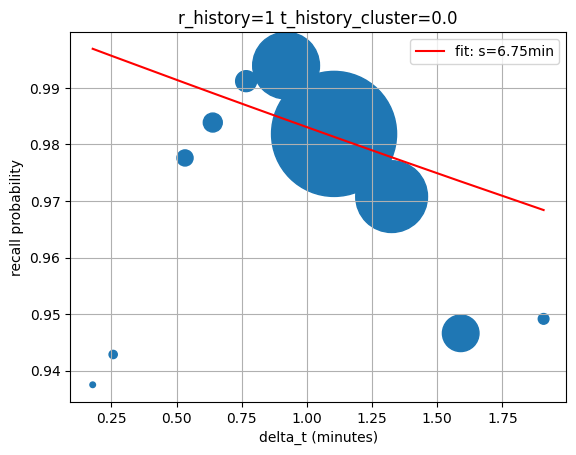

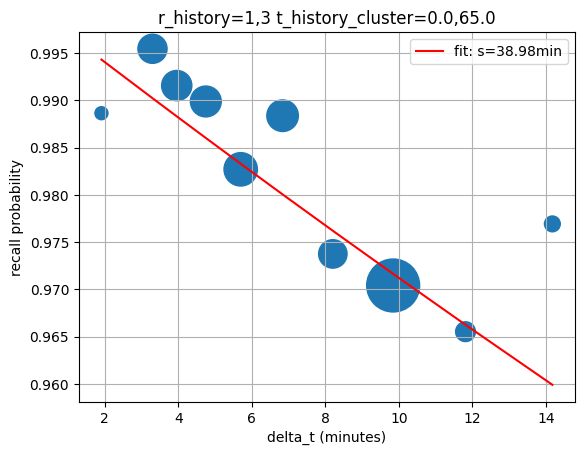

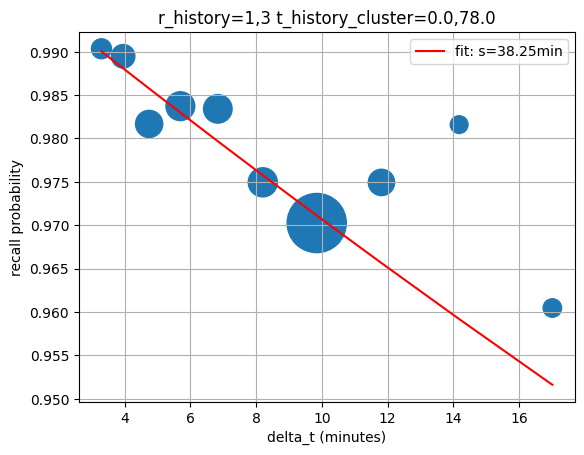

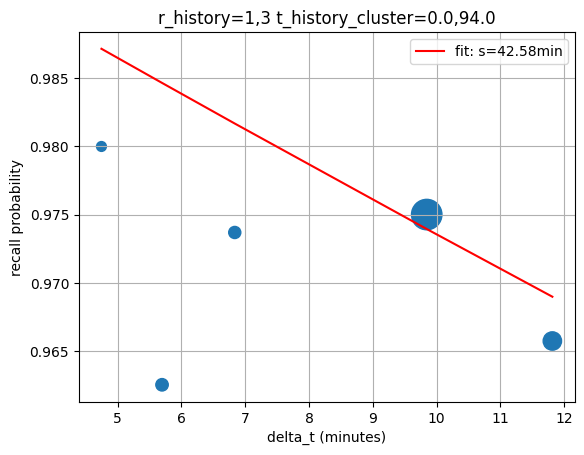

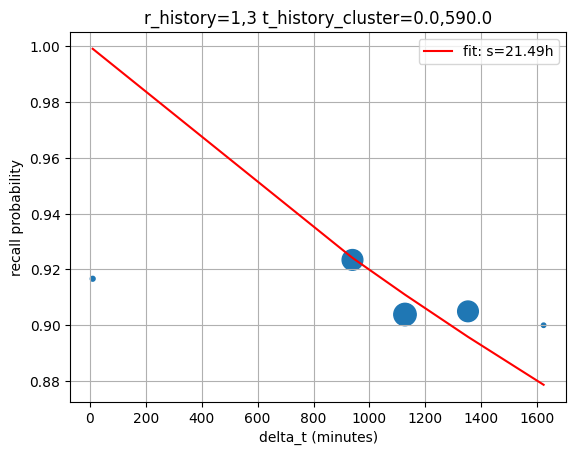

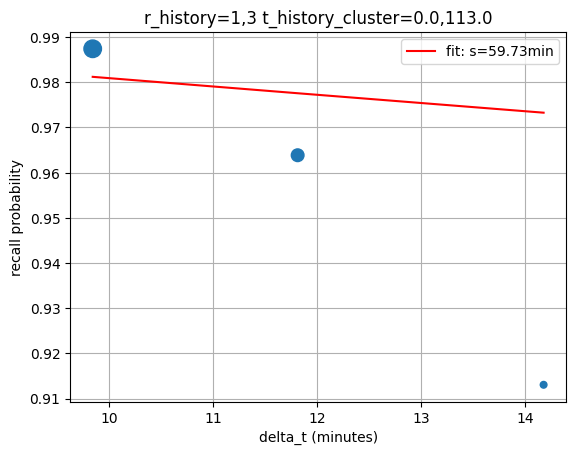

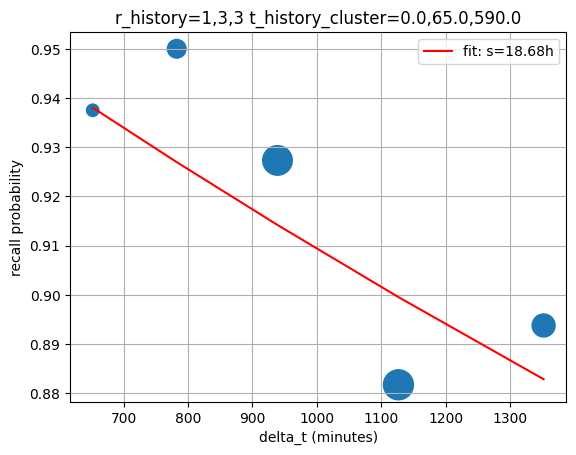

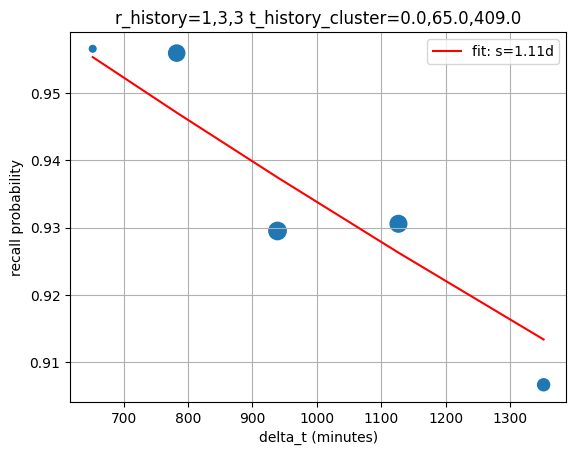

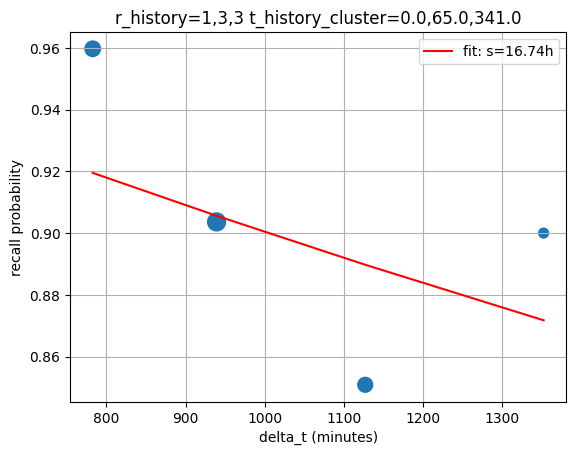

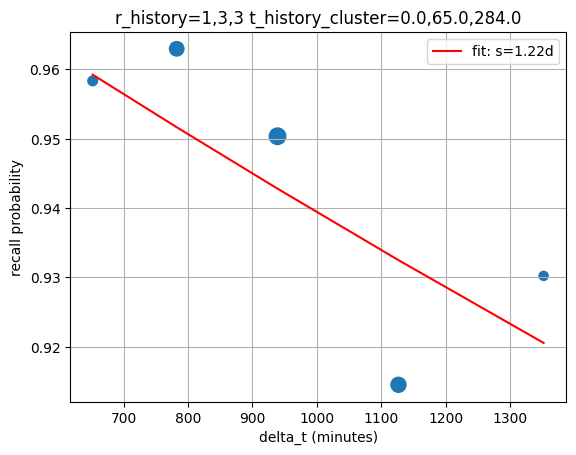

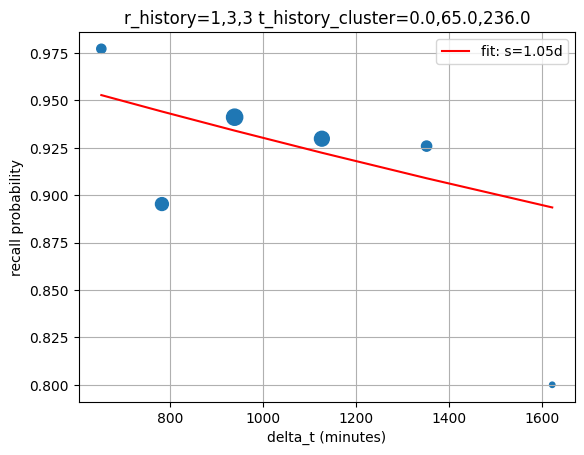

In [5]:
t_tmp = '0.0'
for r_history in ("1", "1,3", "1,3,3"):
    for i, t_history_cluster in enumerate(df[(df["r_history"] == r_history) & (df['t_history_cluster'].str.startswith(t_tmp))]["t_history_cluster"].value_counts().head(5).index):
        if i == 0:
            t_tmp = t_history_cluster
        df["t_bin"] = df["delta_t"].map(lambda x: round(
            math.pow(BASE, math.floor(math.log(x, BASE))), 2) if x > 0 else 0)
        df["y"] = df["rating"].map(lambda x: 1 if x > 1 else 0)
        tmp = df[(df["r_history"] == r_history) & (df["t_history_cluster"] == t_history_cluster)].groupby("t_bin").agg(
            {"y": ["mean", "count"]}).reset_index().copy()
        tmp = tmp[(tmp["y"]["count"] >= 10) & (tmp["y"]["mean"] < 1)]
        if tmp.empty:
            continue
        plt.scatter(tmp["t_bin"]/60, tmp[("y", "mean")], s=tmp[("y", "count")])
        popt, pcov = curve_fit(power_forgetting_curve, tmp["t_bin"], tmp[(
            "y", "mean")], sigma=1/tmp[("y", "count")])
        stability = f"{popt[0]:.2f}s" if popt[0] < 60 else f"{popt[0]/60:.2f}min" if popt[0] < 3600 else f"{popt[0]/3600:.2f}h" if popt[0] < 86400 else f"{popt[0]/86400:.2f}d"
        plt.plot(tmp["t_bin"]/60, power_forgetting_curve(
            tmp["t_bin"], *popt), 'r-', label=f'fit: s={stability}')
        plt.title(f"r_history={r_history} t_history_cluster={t_history_cluster}")
        plt.xlabel("delta_t (minutes)")
        plt.ylabel("recall probability")
        plt.legend()
        plt.grid()
        plt.show()